# Transformers with MetaQuantus

This notebook gives the instructions for how to get started with MetaQuantus, with methods explained in the paper:

[**The Meta-Evaluation Problem in Explainable AI:
Identifying Reliable Estimators with MetaQuantus**](https://arxiv.org/abs/2302.07265)

If you want to reproduce the experiments in the paper, please see the separate notebook **Reproduce-Experiments.ipynb**.

We will use the ImageNet dataset and different transformer models for demonstration. Make sure to have GPU enabled for performance gains.

## Transformers XAI methods

### Self-attention maps

In [ ]:
%%capture
!pip install quantus transformers transformers_interpret metaquantus captum torchvision timm==0.6.12 transformers==4.24.0 ftfy -qqq

Customise local paths

In [ ]:
import quantus
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from transformers_interpret import ImageClassificationExplainer

torch.__version__

# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
PATH_DATA = PATH_ASSETS + "data/"

# Import local packages.
import sys
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/MetaQuantus')
import metaquantus

Mounted at /content/drive


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

150


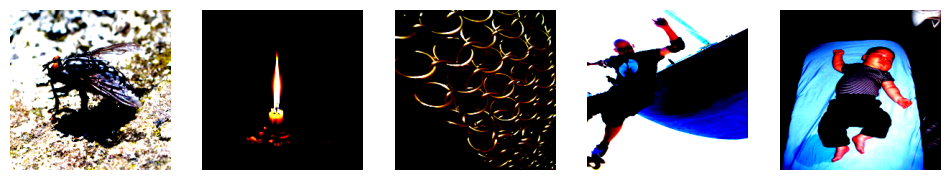

In [ ]:
from metaquantus import setup_dataset_models, setup_xai_settings, setup_estimators

# Load data.
dataset_name = "ImageNet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(224, 224, 3))
    ax[i].axis("off")
plt.show()

In [ ]:
import timm
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
model = timm.create_model(model_name='deit_tiny_distilled_patch16_224',
                          pretrained=True);

Let's explore the model’s decision-making strategies. Since the model is based on transformer architecture, we can plot the histograms of attention of the heads of each transformer block. [3]

Let's define the wrapper for the forward function of the Attention object

In [ ]:
https://discuss.pytorch.org/t/extracting-self-attention-maps-from-nn-transformerencoder/139998/2

In [ ]:
def attn_forward_wrapper(attn_obj):
    def forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)

        # Store attention map in the Attention object
        attn_obj.attn_map = attn

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return forward

Wrap the attention forward method in all model blocks

In [ ]:
for i in range(12):
    model.blocks[i].attn.forward = attn_forward_wrapper(model.blocks[i].attn)

Define auxilary functions to get the attention masks from the model

In [ ]:
def get_blocks_attn(model):
    """
    Returns list of attention maps from all the model blocks
    """
    attn_hist_list = []
    for i in range(12):
        attn_map = model.blocks[i].attn.attn_map.detach()
        attn_map = attn_map.squeeze(0)
        # attn_hist_rgb = attn_map.mean(1)[:, 2:].reshape(1, 3, 14, 14)
        attn_hist_rgb = attn_map[:, 0, 2:].reshape(1, 3, 14, 14)
        attn_hist_list.append(attn_hist_rgb)
    attn_hist = torch.cat(attn_hist_list)
    return attn_hist

In [ ]:
def get_mean_attn_hist(model):
    """
    Returns the average attention mask from list of attention maps
    """
    attn_hist_mean = get_blocks_attn(model)
    attn_hist_mean = torch.mean(attn_hist_mean, dim=0)
    attn_hist_mean = F.interpolate(attn_hist_mean.unsqueeze(0),
                                size = (224, 224),
                                mode='bilinear')
    attn_hist_mean = attn_hist_mean.mean(1).permute(1, 2, 0)
    return attn_hist_mean

Plot the average attention mask across all transformer blocks

In [ ]:
attn_hist_mean.shape

torch.Size([224, 224, 1])

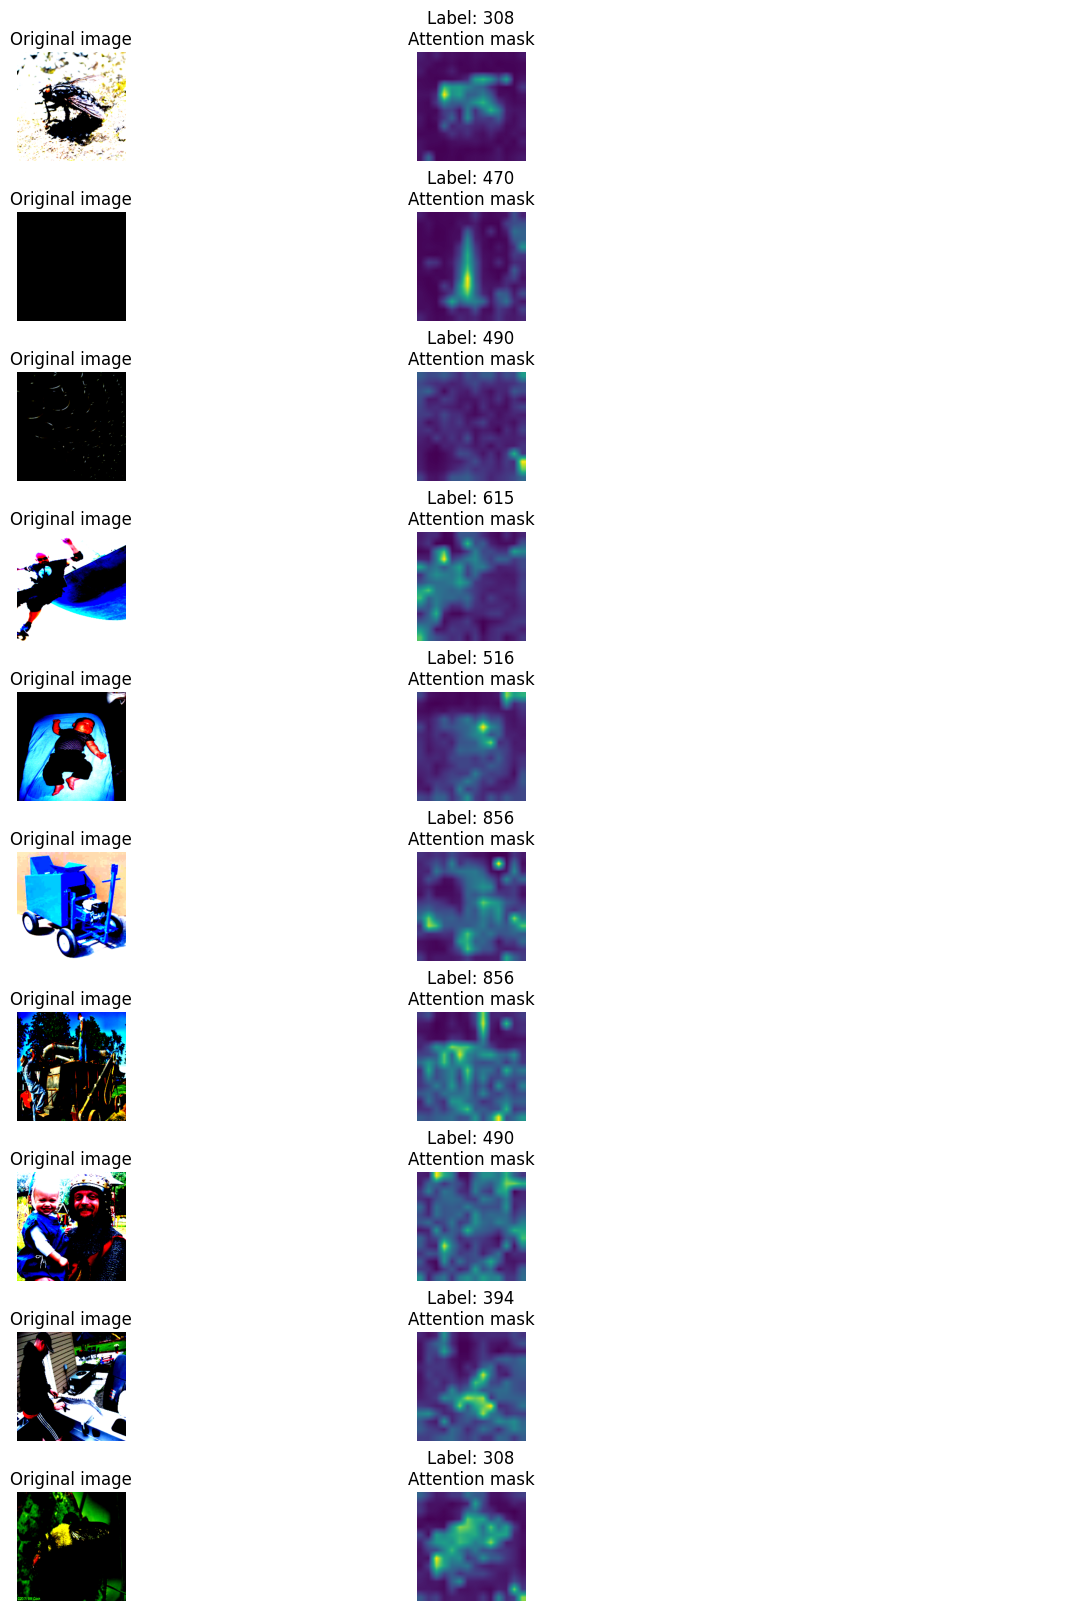

In [ ]:
model.eval()
model.to(device)

nr_samples = 10
fig, ax = plt.subplots(nr_samples, 3, constrained_layout=True, figsize=(3*4, 4*4))
for a in ax.flatten(): a.set_axis_off()

for i, (image, label) in enumerate(zip(x_batch, y_batch)):
    
    if i < nr_samples:
        image = torch.Tensor(image)
        image_plot = image.permute(1, 2, 0)
        image_plot = image_plot * torch.Tensor(image.std())
        image_plot = image_plot + torch.Tensor(image.mean())
        ax[i, 0].imshow(image_plot)
        #ax[i, 2].imshow(image_plot)

        model(image.unsqueeze(0).to(device))
        attn_hist_mean = get_mean_attn_hist(model)
        attn_hist_mean = attn_hist_mean.cpu()
        ax[i, 1].imshow(attn_hist_mean, alpha=1)
        #ax[i, 2].imshow(attn_hist_mean, alpha=0.7)

        ax[i, 0].set_title('Original image')
        ax[i, 1].set_title(f'Label: {str(label).title()}\nAttention mask')
        #ax[i, 2].set_title('Image with attention mask')

Additionally, let's plot the attention masks for each transformer block separately

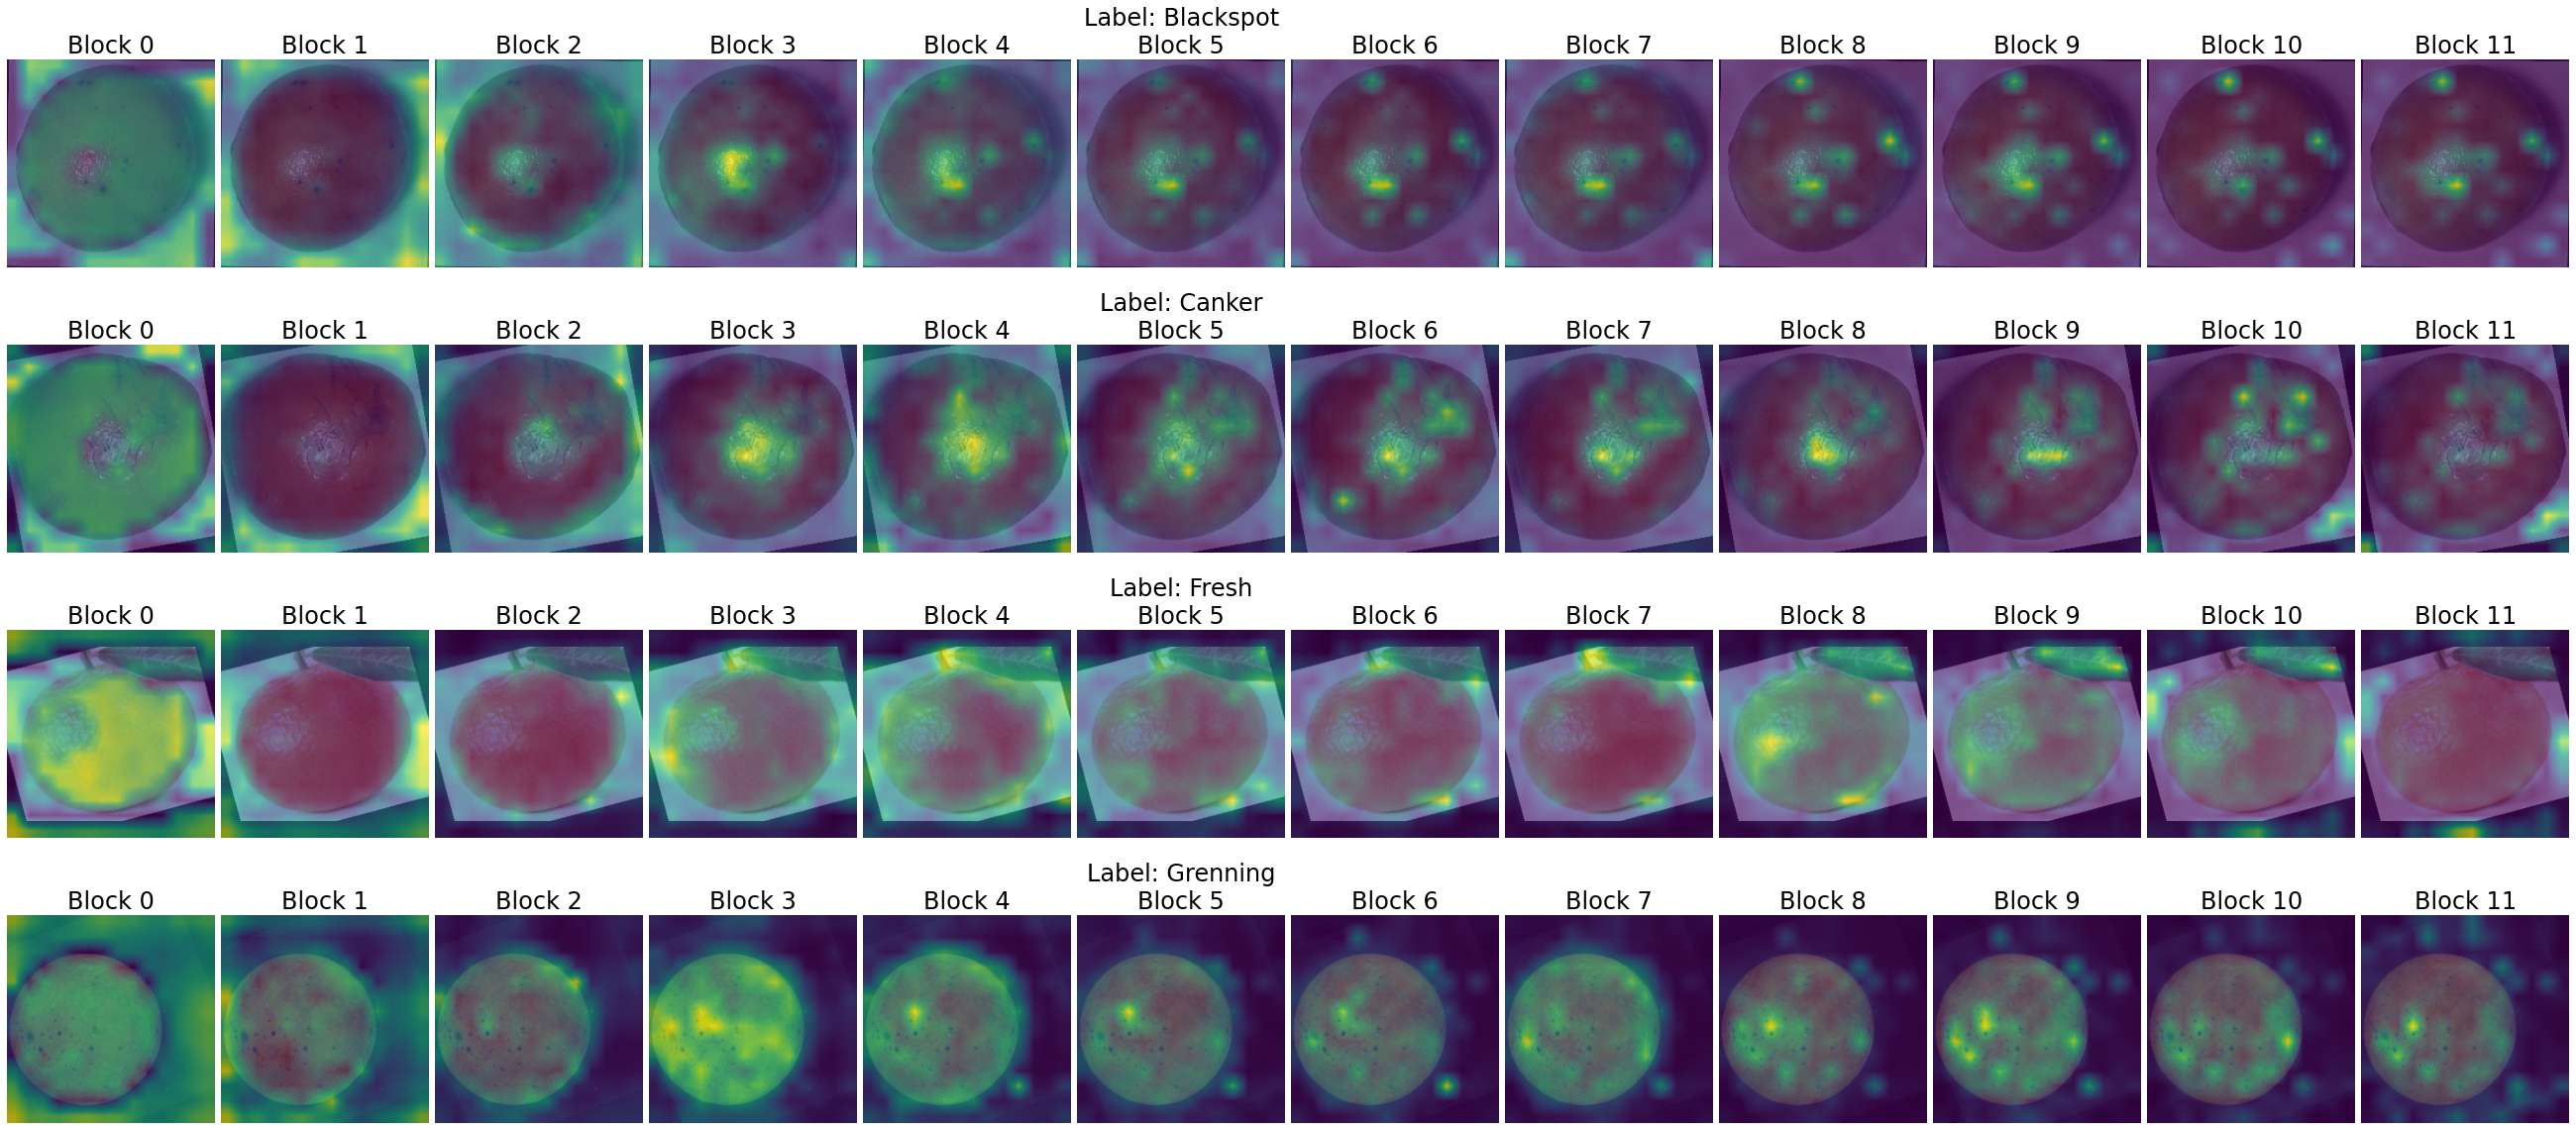

In [ ]:
fig, ax = plt.subplots(4, 12, constrained_layout=True, figsize=(12*3, 4*4))
for a in ax.flatten(): a.set_axis_off()

for i, sample in enumerate(dataset_vis):
    image = sample[0]
    label = sample[1]

    image_plot = image.permute(1, 2, 0)
    image_plot = image_plot * torch.tensor(dataset_vis._std)
    image_plot = image_plot + torch.tensor(dataset_vis._mean)
    for j in range(12):
        ax[i, j].imshow(image_plot)

    model(image.unsqueeze(0).to(device))
    attn_blocks = get_blocks_attn(model)
    for j, attn_block in enumerate(attn_blocks):
        attn_hist_mean = F.interpolate(attn_block.unsqueeze(0),
                                       size = (224, 224),
                                       mode='bilinear')
        attn_hist_mean = attn_hist_mean.mean(1).permute(1, 2, 0)
        attn_hist_mean = attn_hist_mean.cpu()
        ax[i, j].imshow(attn_hist_mean, alpha=0.7)
        ax[i, j].set_title(f'Block {j}')
        ax[i, j].title.set_size(24)

    ax[i, 5].set_title(f'Label: {label.title()}\nBlock 5')
    ax[i, 5].title.set_size(24)

As we can see, the model pays special attention to the reflection of the camera flash of the first 2 clases in the dataset. It also pays attention to the presence of a green leaf, which is only present in samples of one class in provided dataset. The model might not generalize well, and the test set metrics are misleading due to the data leakage. The model, ideally, should be trained and evaluated on a different dataset, collected with variety of scenes and pre-processed to remove any factors that could introduce such a bias. However, having a better set of augmentations during the model training could allow the model to generalize better even with the current dataset, which should be explored further.

### Attention-Rollout

In [ ]:
!pip install torchvision timm metaquantus quantus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.6/279.6 KB 15.2 MB/s eta 0:00:00


Customise local paths

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import quantus

In [ ]:
# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
PATH_DATA = PATH_ASSETS + "data/"

# Import local packages.
import sys
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/MetaQuantus')
import metaquantus

Mounted at /content/drive


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


150


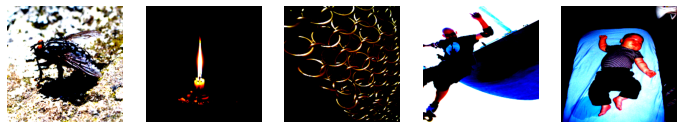

In [ ]:
from metaquantus import setup_dataset_models, setup_xai_settings, setup_estimators

# Load data.
dataset_name = "ImageNet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(224, 224, 3))
    ax[i].axis("off")
plt.show()

In [ ]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

def grad_rollout(attentions, gradients, discard_ratio, **kwargs):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention, grad in zip(attentions, gradients):                
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)

    img_size = kwargs.get("img_size", 224)
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

    return mask    

class VITAttentionGradRollout:
    def __init__(self, model, attention_layer_name='attn_drop',
        discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        category_mask = torch.zeros(output.size())
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()

        return grad_rollout(self.attentions, self.attention_gradients, self.discard_ratio)


In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
img_size = 224 

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [ ]:
def explain_with_rollout(model, inputs, targets, **kwargs):
    attention_rollout = VITAttentionGradRollout(model=model, discard_ratio=0.9)
    return attention_rollout(input_tensor=inputs, category_index=targets)
    

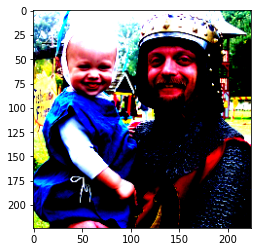

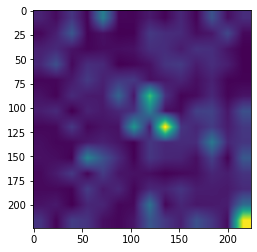

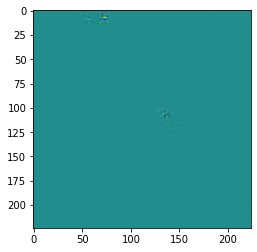

In [ ]:
index = np.random.choice(range(len(x_batch)))
input_tensor = torch.Tensor(x_batch[index].reshape(1, 3, img_size, img_size))
logit = int(y_batch[index])

#model = torchvision.models.vit_b_16(pretrained=True)
explanation_1 = explain_with_rollout(model, input_tensor, logit)
explanation_2 = quantus.explain(model, input_tensor, y_batch[index], **{"method": "GradientShap"}).reshape(img_size, img_size)
#explanation_3 = explain_with_relevance(model, input_tensor, logit)

plt.imshow(np.moveaxis(input_tensor.numpy().reshape(3, 224, 224), 0, -1).reshape(224, 224, 3))
plt.show()
plt.imshow(explanation_1)
plt.show()
plt.imshow(explanation_2)
plt.show()
#plt.imshow(explanation_3)
#plt.show()

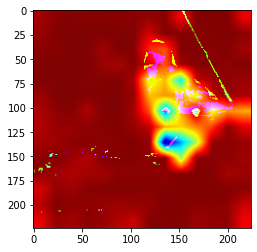

In [ ]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

plt.imshow(show_mask_on_image(np.moveaxis(input_tensor.numpy().reshape(3, 224, 224), 0, -1).reshape(224, 224, 3), explanation_1))

In [ ]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

input_tensor

### Relevance roll-out

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install -r requirements.txt

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 386 (delta 3), reused 2 (delta 0), pack-reused 377
Receiving objects: 100% (386/386), 3.85 MiB | 8.26 MiB/s, done.
Resolving deltas: 100% (194/194), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.6/274.6 KB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 59.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata 

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [ ]:
# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, inputs, targets=None, **kwargs):
    output = model(inputs, register_hook=True)
    if targets == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, targets] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for blk in model.blocks:
        grad = blk.attn.get_attn_gradients()
        cam = blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    return R[0, 1:]

In [ ]:
%%capture
!pip install einops
import einops

In [ ]:
#@title Imagenet class indices to names
%%capture
CLS2IDX = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [ ]:
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model = vit(pretrained=True).cuda()
model.eval()

def explain_with_relevance(model, inputs, targets=None, **kwargs):
    transformer_attribution = generate_relevance(model, inputs.unsqueeze(0).cuda(), targets, **kwargs).detach()
    print(transformer_attribution.shape)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = inputs.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [ ]:
%%capture 
!pip install timm torchvision
import timm
import torchvision

torch.Size([196])


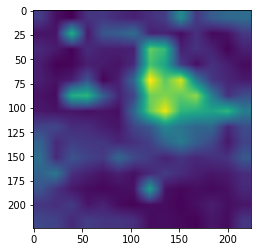

In [ ]:
model = vit(pretrained=True).cuda()
#model = torchvision.models.swin_t(pretrained=True)
cat, transformer_attribution = explain_with_relevance(model, input_tensor.reshape(3, img_size, img_size), targets=logit)
plt.imshow(transformer_attribution)

torch.Size([1, 3, 224, 224])

Top 5 classes:
	282 : tiger cat       		value = 10.558	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.058	 prob = 15.3%
	285 : Egyptian cat    		value = 8.413	 prob = 8.0%
	243 : bull mastiff    		value = 7.426	 prob = 3.0%
	811 : space heater    		value = 5.151	 prob = 0.3%


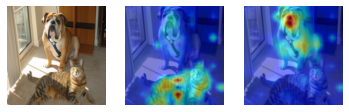

In [ ]:
image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat, transformer_attribution = generate_visualization(dog_cat_image)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog, transformer_attribution = generate_visualization(dog_cat_image, class_index=243)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

### transformers-interpret

In [ ]:
import torchvision
import torch
#import transformers_interpret
#import transformers

In [ ]:
!pip show transformers_interpret

Name: transformers-interpret
Version: 0.9.6
Summary: Model explainability that works seamlessly with 🤗 transformers. Explain your transformers model in just 2 lines of code.
Home-page: 
Author: Charles Pierse
Author-email: charlespierse@gmail.com
License: 
Location: /usr/local/lib/python3.8/dist-packages
Requires: captum, ipython, transformers
Required-by: 


In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from transformers_interpret import ImageClassificationExplainer
from PIL import Image
import requests

print(transformers.__version__)

model_name = "google/vit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# With both the model and feature extractor initialized we are now able to get explanations on an image, we will use a simple image of a golden retriever.
image_link = "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F47%2F2020%2F08%2F16%2Fgolden-retriever-177213599-2000.jpg"

image = Image.open(requests.get(image_link, stream=True).raw)

image_classification_explainer = ImageClassificationExplainer(model=model, 
                                                              feature_extractor=feature_extractor)

image_attributions = image_classification_explainer(
    image
)

print(image_attributions.shape)

image_classification_explainer.visualize()

image_classification_explainer.visualize(
    method="heatmap",
    #side_by_side=False,
    #outlier_threshold=0.03,
    #save_path="./explainer_image.png",
    #attribution_type="IG"

)

In [ ]:
for d in dir(image_classification_explainer):
    if not d.startswith("_"):
        attr = getattr(image_classification_explainer, d)
        if isinstance(attr, (int, float, str)):
            #print(d, type(getattr(image_classification_explainer, d)))
            print(d, getattr(image_classification_explainer, d))

attribution_type IGNT
n_steps 50
n_steps_noise_tunnel 5
noise_tunnel_n_samples 10
noise_tunnel_type smoothgrad
predicted_index 207
selected_index 207


Loading CIFAR-100

In [ ]:
#model = dataset_settings[dataset_name]["models"]["ResNet9"].eval()
#model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

In [ ]:
# https://github.com/jeonsworld/ViT-pytorch/blob/main/utils/data_utils.py
"""
 transform_train = transforms.Compose([
        transforms.RandomResizedCrop((args.img_size, args.img_size), scale=(0.05, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

trainset = datasets.CIFAR100(root="./data",
                            train=True,
                            download=True,
                            transform=transform_train)
testset = datasets.CIFAR100(root="./data",
                        train=False,
                        download=True,
                        transform=transform_test)

train_sampler = RandomSampler(trainset) if args.local_rank == -1 else DistributedSampler(trainset)
    test_sampler = SequentialSampler(testset)
    train_loader = DataLoader(trainset,
                              sampler=train_sampler,
                              batch_size=args.train_batch_size,
                              num_workers=4,
                              pin_memory=True)
    test_loader = DataLoader(testset,
                             sampler=test_sampler,
                             batch_size=args.eval_batch_size,
                             num_workers=4,
                             pin_memory=True) if testset is not None else None
""";

Normal imports

In [ ]:
!pip install matplotlib==3.5.1
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch torchvision
!pip install captum>=0.4.1
!pip install quantus>=0.3.4
#!pip install transformers-interpret
#!pip install transformers

In [ ]:
!pip install torch==1.13.1
!pip install torchvision==0.14.1

In [ ]:
import torchvision
import torch

In [ ]:
# List available models 
all_models = torchvision.models.list_models() 
classification_models = torchvision.models.list_models(module=torchvision.models)

# Download ViT.
# https://console.cloud.google.com/storage/browser/vit_models;tab=objects?pli=1&prefix=&forceOnObjectsSortingFiltering=false 
# https://github.com/jeonsworld/ViT-pytorch

In [ ]:
# Import libraries.
from IPython.display import clear_output
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum 
import quantus
warnings.filterwarnings("ignore", category=UserWarning)
clear_output()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', torch.cuda.get_device_name(0))
!nvidia-smi

Using device: Tesla T4
Fri Mar  3 18:52:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

Customise local paths

In [ ]:
# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
PATH_DATA = PATH_ASSETS + "data/"

# Import local packages.
import sys
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/MetaQuantus')
import metaquantus

Mounted at /content/drive


Huggingface imports

Customise local paths

In [ ]:
%%capture
!pip install quantus transformers transformers_interpret metaquantus captum torchvision

import quantus
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from transformers_interpret import ImageClassificationExplainer

torch.__version__

# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
PATH_DATA = PATH_ASSETS + "data/"

# Import local packages.
import sys
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/MetaQuantus')
import metaquantus

Load dataset

150


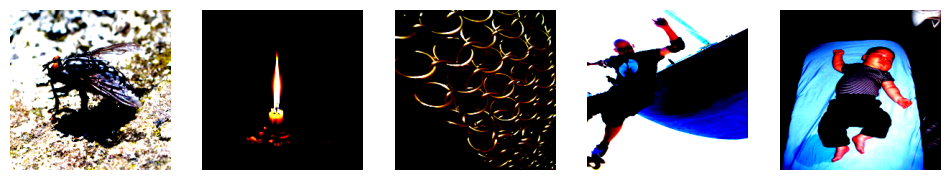

In [ ]:
from metaquantus import setup_dataset_models, setup_xai_settings, setup_estimators

# Load data.
dataset_name = "ImageNet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(224, 224, 3))
    ax[i].axis("off")
plt.show()

Load model

In [ ]:
# Supporting functions for the model.
def return_tensor(self):
    def hook(module, input, output):
        return output.logits
    self.handle = self.register_forward_hook(hook)

def return_hf_type(self):
    self.handle.remove()

In [ ]:
def load_vit_model():

    # Load the model.
    model_name = "google/vit-base-patch16-224"
    model = AutoModelForImageClassification.from_pretrained(model_name)
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

    # Set the functions as methods of the PyTorch class.
    model.return_tensor = return_tensor
    model.return_hf_type = return_hf_type

    return model

Available explanation methods

```python
from enum import Enum, unique
@unique
class AttributionType(Enum):
    INTEGRATED_GRADIENTS = "IG"
    INTEGRATED_GRADIENTS_NOISE_TUNNEL = "IGNT"
class NoiseTunnelType(Enum):
    SMOOTHGRAD = "smoothgrad"
    SMOOTHGRAD_SQUARED = "smoothgrad_sq"
    VARGRAD = "vargrad"
```

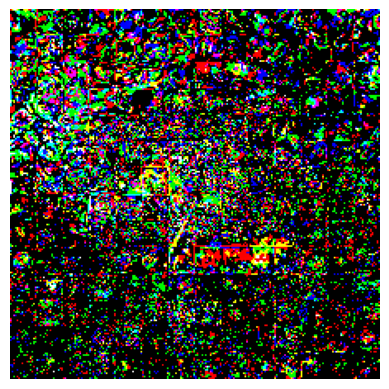

In [ ]:
# Define the explainer with hf model.
image_classification_explainer = ImageClassificationExplainer(model=model, feature_extractor=feature_extractor, attribution_type="IG")

# Get attributions.
image_attributions = image_classification_explainer(x_batch[0])

# Plot!
plt.imshow(np.moveaxis(image_attributions[0] * 255, 0, -1).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
plt.axis("off")
plt.show()

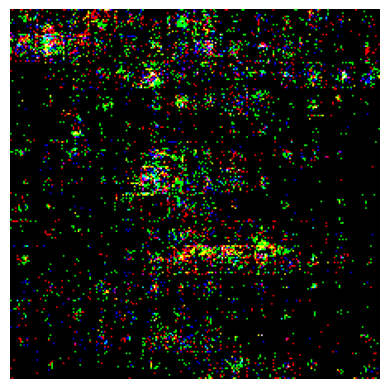

In [ ]:
# Define the explainer with hf model.
image_classification_explainer = ImageClassificationExplainer(model=model, feature_extractor=feature_extractor, attribution_type="IGNT")

# Get attributions.
image_attributions = image_classification_explainer(x_batch[0])

# Plot!
plt.imshow(np.moveaxis(image_attributions[0] * 255, 0, -1).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
plt.axis("off")
plt.show()



The annoying part is HF special output class, e.g, https://github.com/huggingface/transformers/blob/main/src/transformers/models/vit/modeling_vit.py#L827, which is required by transformers-interpret but breaks Quantus. The main idea is: return plain tensor for calls from quantus, and ImageClassifierOutput for calls from transformers-interpret. I've used hacky solution here, but this could be just explicitly handled in Quantus internal model wrapper.

Experimental Setup
Additional sub-experiment include Vision Transformer (ViT) model ImageNet dataset.						
- Using transformers-interpret library
- Model: ViT model VS ResNet-50
- Data: ImageNet
- XAI methods: IG and SmoothGrad IG, unnormalised explanations
XAI metrics: Complexity vs Sparseness


In [ ]:
from captum.attr import NoiseTunnel, IntegratedGradients

def explain_func_torch(model, inputs, targets, **kwargs) -> np.ndarray:
    """Transformer-model specific explain function."""

    # Set model in evaluate mode.
    model.to(device)
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = torch.Tensor(inputs).to(device)

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).to(device)

    # Define the explainer with hf model.
    method = kwargs.get("method", "IG")
    
    if method == "IG":
        attr, _ = IntegratedGradients(model).attribute(
                inputs=inputs,
                target=targets,
                n_steps=10,
                return_convergence_delta=True,
            )
    elif method == "IGNT":
        attr, _ = NoiseTunnel(IntegratedGradients(model)).attribute(
                inputs=inputs,
                target=targets,
                n_steps=10,
                return_convergence_delta=True,
                nt_type="smoothgrad",
                nt_samples=5, 
            )
        

    if isinstance(attr, torch.Tensor):
        if attr.requires_grad:
            attr = attr.cpu().detach().numpy()
        else:
            attr = attr.cpu().numpy()
    return attr.sum(axis=1)

    #, index=targets

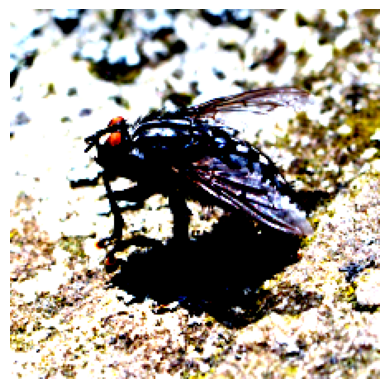

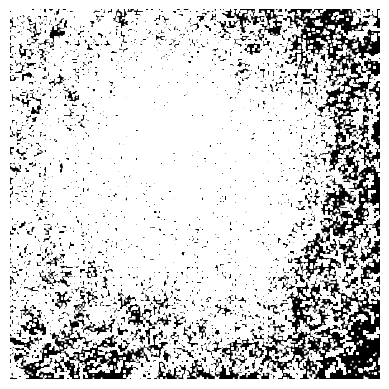

In [ ]:
import torchvision

# Test run!
def load_resnet_model():
    # New weights with accuracy 80.858%
    return torchvision.models.resnet50(pretrained=True)

model = load_resnet_model()

# Generate explanations.
a_batch = explain_func_torch(
    model=model,
    inputs=x_batch[:1],
    targets=y_batch[:1],
    **{"method": method}
)

# Plot!
plt.imshow(np.moveaxis(x_batch[0], 0, -1).reshape(224, 224, 3))
plt.axis("off")
plt.show()
plt.imshow(np.moveaxis(a_batch[0] * 255, 0, -1).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
def explain_func_transformer(model, inputs, targets, **kwargs) -> np.ndarray:
    """Transformer-model specific explain function."""
    
    # Model type, huggingface.
    model.return_hf_type(model)

    # Define the explainer with hf model.
    method = kwargs.get("method", "IG")
    image_classification_explainer = ImageClassificationExplainer(model=model, 
                                                                  feature_extractor=feature_extractor, 
                                                                  attribution_type=method,
                                                                  #n_steps=10, 
                                                                  #nt_type="smoothgrad",
                                                                  #noise_tunnel_n_samples=5,
                                                                  #nt_samples=5
                                                                  )

    # Get attributions.
    attr = image_classification_explainer(image=inputs[0], index=int(targets[0])).sum(axis=1)
    
    #attr = np.asarray([image_classification_explainer(i)[0] for i in inputs]).sum(axis=1)
    #print(type(attr), attr.shape)

    # Model type, reset.
    model.return_tensor(model)
    
    return attr

    #, index=targets

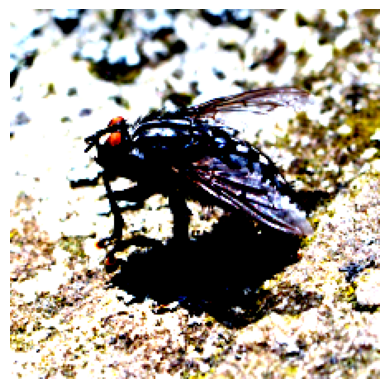

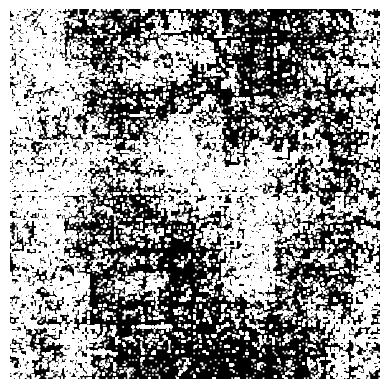

In [ ]:
# Test run!
model = load_vit_model()
model.return_tensor(model)

# Generate explanations.
a_batch = explain_func_transformer(
    model=model,
    inputs=x_batch[:1],
    targets=y_batch[:1],
    **{"method": method}
)

# Plot!
plt.imshow(np.moveaxis(x_batch[0], 0, -1).reshape(224, 224, 3))
plt.axis("off")
plt.show()
plt.imshow(np.moveaxis(a_batch[0] * 255, 0, -1).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
# Run one sample!
model = load_vit_model()
model.return_tensor(model)

s = 0
method = "IG"

quantus.Complexity(
    display_progressbar=True,
    disable_warnings=True,
    abs=True,
)(
    model,
    x_batch[s].reshape(1, 3, 224, 224),
    np.asarray([y_batch[s]]),
    explain_func=explain_func_transformer,
    explain_func_kwargs={"method": method},
    softmax=False,
    channel_first=True,
)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Evaluating Complexity:   0%|          | 0/1 [00:00<?, ?it/s]

[9.958613970895286]

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

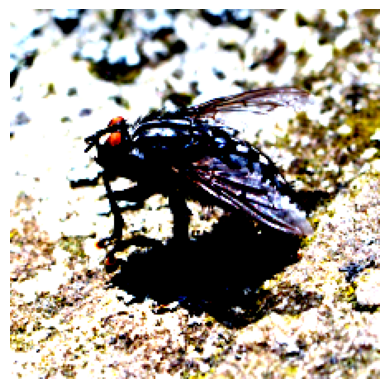

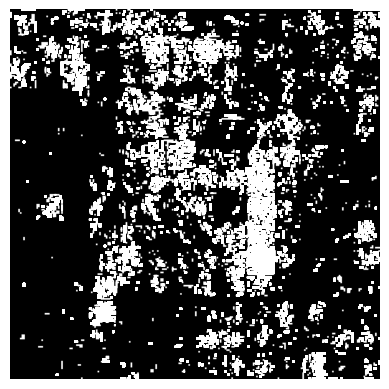

In [ ]:
import torchvision

# Test run!
def load_resnet_model():
    # New weights with accuracy 80.858%
    return torchvision.models.resnet50(pretrained=True)

# Test run!
def load_vit_b_16_model():
    # New weights with accuracy 80.858%
    return torchvision.models.vit_b_16(pretrained=True)

model = load_vit_b_16_model()

# Generate explanations.
a_batch = explain_func_torch(
    model=model,
    inputs=x_batch[:1],
    targets=y_batch[:1],
    **{"method": method}
)

# Plot!
plt.imshow(np.moveaxis(x_batch[0], 0, -1).reshape(224, 224, 3))
plt.axis("off")
plt.show()
plt.imshow(np.moveaxis(a_batch[0] * 255, 0, -1).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
# Run several samples!
model = load_vit_model()
model.return_tensor(model)

samples = 10
methods = ["IG", "IGNT"]
architectures = ["resnet", "vit"]

complexity_scores = {}

for architecture in architectures:
    complexity_scores[architecture] = {}

    if architecture == "vit":
        model = load_vit_model()
        model.return_tensor(model)
        explain_func = explain_func_transformer
    elif architecture == "resnet":
        model = load_resnet_model()
        explain_func = explain_func_torch

    for method in methods:
        complexity_scores[architecture][method] = []
        for s in range(samples):

            score = quantus.Sparseness(
                display_progressbar=True,
                disable_warnings=True,
                abs=True,
            )(
                model,
                x_batch[s].reshape(1, 3, 224, 224),
                np.asarray([y_batch[s]]),
                explain_func=explain_func,
                explain_func_kwargs={"method": method},
                softmax=False,
                channel_first=True,
            )
            complexity_scores[architecture][method].append(score[0])

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Sparseness:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
complexity_scores

{'resnet': {'IG': [0.63486977029823,
   0.5467748774145765,
   0.5467761135786672,
   0.5734173380715086,
   0.5395958403083086,
   0.5543418660310588,
   0.5787751466119664,
   0.6156526871600504,
   0.7064654319967452,
   0.647617286622906],
  'IGNT': [0.6530594059887607,
   0.5713649047460723,
   0.4964247368181657,
   0.5466316162122576,
   0.5022412551453361,
   0.5153742797685615,
   0.5672046802886468,
   0.5165315071004732,
   0.5344243296114801,
   0.6189936516070037]},
 'vit': {'IG': [0.6534070546475754,
   0.571131470517895,
   0.5505268992519808,
   0.5321978516410324,
   0.5491545651577322,
   0.5316006295495775,
   0.5527799191739577,
   0.54107757780095,
   0.5678891808218536,
   0.5532879337401545],
  'IGNT': [0.5442028366066846,
   0.5111013984031396,
   0.5348240422727696,
   0.5142872713867734,
   0.4872030989212016,
   0.5323802756365285,
   0.5238408795266104,
   0.5243162496270528,
   0.5003575971794904,
   0.5065855683818715]}}

In [ ]:
# Sparseness.
np.array(list(complexity_scores["resnet"].values())).mean(), np.array(list(complexity_scores["vit"].values())).mean()

(0.5733268362690389, 0.5391076150122415)

In [ ]:
# Complexity.
complexity_scores

{'resnet': {'IG': [10.054277824874445,
   10.296235708751643,
   10.30047226213145,
   10.230724278771374,
   10.314487449848672,
   10.278042155099783,
   10.227845344652888,
   10.113036019740022,
   9.8073266178647,
   10.038835445923274],
  'IGNT': [10.001179006845762,
   10.159260767202056,
   10.412168908046528,
   10.286270752634453,
   10.395412134580381,
   10.350480770449327,
   10.23235099931867,
   10.367912921357535,
   10.346773698392626,
   10.083040019013751]},
 'vit': {'IG': [9.958613970895286,
   10.223815171352436,
   10.256063773813116,
   10.322697227072112,
   10.282083392727838,
   10.32471453373787,
   10.26259892239478,
   10.298951110165165,
   10.224303225562329,
   10.278289888552086],
  'IGNT': [10.287152990984676,
   10.371323966490932,
   10.364529237448997,
   10.342188041880235,
   10.401400087435848,
   10.301122512041637,
   10.2888383446395,
   10.400134825645814,
   10.384961974873008,
   10.375180494877746]}}

Identified Limitations

- [x] `transformers-interpret` does not work on batches
- [x] LOL and they hardcode every IG hyperparam!!!
- [x] XAI methods, since MetaQuantus is a layer on Quantus, the explanation type must be feature importances 



"""
quantus.PixelFlipping(
    display_progressbar=True,
    disable_warnings=True,
    features_in_step=784,
)(
    model,
    x_batch[:1],
    y_batch[:1],
    explain_func=explain,
    softmax=False
)
""";

## 1) Preliminaries

In [ ]:
from metaquantus import setup_dataset_models, setup_xai_settings, setup_estimators

ModuleNotFoundError: ignored

### 1.1 Load data

In [ ]:
# Load data.
dataset_name = "ImageNet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(224, 224, 3))
    ax[i].axis("off")
plt.show()

### 1.2 Load explanations

In [ ]:
# Test run!
def load_resnet_model():
    # New weights with accuracy 80.858%
    return torchvision.models.resnet50(pretrained=True)

# Test run!
def load_vit_b_16_model():
    # New weights with accuracy 80.858%
    return torchvision.models.vit_b_16(pretrained=True)

model_resnet = load_resnet_model()
model_vit_b_16 = load_vit_b_16_model()
model_resnet.eval().to(device)
model_vit_b_16.eval().cpu();

In [ ]:
# Load explanations.
xai_setting = ["IntegratedGradients", "Saliency"]
xai_methods = setup_xai_settings(
    xai_settings=xai_setting,
    gc_layer=dataset_settings[dataset_name]["gc_layers"][model_name],
    img_size=dataset_kwargs["img_size"],
    nr_channels=dataset_kwargs["nr_channels"],
)

# Generate explanations.
explanations = {}
for method, kwargs in xai_methods.items():
    #model = dataset_settings[dataset_name]["models"]["ResNet9"].eval().cpu()
    model = model_vit_b_16.eval().cpu()
    explanations[method] = quantus.explain(model=model, inputs=x_batch[:5], targets=y_batch[:5], **{**{"method": method}, **kwargs})

explanations

/usr/local/lib/python3.9/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


{'IntegratedGradients': array([[[[-1.12147501e-03, -2.02149898e-03, -3.89685389e-03, ...,
           -8.86301976e-04, -6.23798463e-04, -6.13537908e-04],
          [-8.22377391e-04,  6.81230682e-04, -6.22091000e-04, ...,
           -1.72461136e-04, -2.06937868e-04, -4.96391323e-04],
          [-6.15117373e-04,  1.42364937e-03,  6.07442576e-04, ...,
            1.24255617e-04, -6.06705580e-05, -6.50135626e-04],
          ...,
          [-7.57245952e-03, -2.26055388e-03, -1.37634308e-03, ...,
           -8.14974832e-04,  3.67677596e-04, -1.86710851e-03],
          [-5.59379347e-03, -3.41047533e-04, -7.75775698e-04, ...,
           -5.21485752e-04,  2.21181792e-04, -1.45136658e-03],
          [-3.38033051e-03,  5.51983248e-04, -4.12733573e-03, ...,
            3.63736181e-04,  2.80057429e-04, -1.14007632e-03]]],
 
 
        [[[-7.99685903e-03, -9.41319298e-03, -1.19835902e-02, ...,
            5.62413735e-03,  2.00494542e-03,  6.80869212e-03],
          [-1.01387198e-03,  6.50469912e-04,  

### 1.3 Load estimators

In [ ]:
# Alt 1. Load initalised Quantus estimators, as provided in MetaQuantus.
estimators = setup_estimators(
    features=dataset_kwargs["features"],
    num_classes=dataset_kwargs["num_classes"],
    img_size=dataset_kwargs["img_size"],
    percentage=dataset_kwargs["percentage"],
    patch_size=dataset_kwargs["patch_size"],
    perturb_baseline="uniform", #dataset_kwargs["perturb_baseline"],
)
estimators

An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.
An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.


{'Robustness': {'Max-Sensitivity': (<quantus.metrics.robustness.max_sensitivity.MaxSensitivity at 0x7f4621f6e850>,
   True),
  'Local Lipschitz Estimate': (<quantus.metrics.robustness.local_lipschitz_estimate.LocalLipschitzEstimate at 0x7f4621f6e040>,
   True)},
 'Randomisation': {'Random Logit': (<quantus.metrics.randomisation.random_logit.RandomLogit at 0x7f4621f6e880>,
   True),
  'Model Parameter Randomisation Test': (<quantus.metrics.randomisation.model_parameter_randomisation.ModelParameterRandomisation at 0x7f4621f6ec10>,
   True)},
 'Faithfulness': {'Faithfulness Correlation': (<quantus.metrics.faithfulness.faithfulness_correlation.FaithfulnessCorrelation at 0x7f4621f6eca0>,
   False),
  'Pixel-Flipping': (<quantus.metrics.faithfulness.pixel_flipping.PixelFlipping at 0x7f4621f6ec40>,
   False)},
 'Complexity': {'Sparseness': (<quantus.metrics.complexity.sparseness.Sparseness at 0x7f4621f6e5b0>,
   False),
  'Complexity': (<quantus.metrics.complexity.complexity.Complexity at 0x7

In [ ]:
# Let's pick 'Pointing-Game' (Localisation metric) and its associated boolean, indicating if lower values are interpreted as better.
estimators['Localisation']['Pointing-Game']

(<quantus.metrics.localisation.pointing_game.PointingGame at 0x7f4621f6e130>,
 False)

In [ ]:
# Alt 2. Define a set of estimators using Quantus, a broader set of Localisation metrics.

estimators_localisation = {
    "Localisation": {
            "Pointing-Game": (
                quantus.PointingGame(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                False,
            ),
             "Top-K Intersection": (quantus.TopKIntersection(
                k=10,
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), False),
             "Relevance Rank Accuracy": (quantus.RelevanceRankAccuracy(
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), False),
            "Relevance Mass Accuracy": (
                quantus.RelevanceMassAccuracy(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                False,
            ),
        }
    }

### 1.4 Load models 

In [ ]:
# Example for how to reload assets and models to notebook.
model_imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)
model_imagenet_vgg16 = torchvision.models.vgg16(pretrained=True)
model_imagenet_vit_b_16 = torchvision.models.vit_b_16(pretrained=True)
model_imagenet_resnet50 = torchvision.models.resnet50(pretrained=True)

dataset_settings[dataset_name]["models"] = {}
dataset_settings[dataset_name]["models"]["ResNet50"] = model_imagenet_resnet50
dataset_settings[dataset_name]["models"]["ViT"] = model_imagenet_vit_b_16

dataset_settings[dataset_name]["models"].keys()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  wa

dict_keys(['ResNet50', 'ViT'])

## 2) Run Meta-Evaluation

In [ ]:
from metaquantus import ModelPerturbationTest, InputPerturbationTest
from metaquantus import MetaEvaluation, MetaEvaluationBenchmarking

### 2.1 Define test suite

We define the Input Perturbation Test and Model Perturbation Test in order to evaluate the estimators.

In [ ]:
# Define test suite.
test_suite = {
        "Model Resilience Test": ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 0.001,
                "type": "Resilience",
            }
        ),
        "Model Adversary Test": ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 2.0,
                "type": "Adversary",
            }
        ),
        "Input Resilience Test": InputPerturbationTest(
            **{
                "noise": 0.001,
                "type": "Resilience",
            }
        ),
        "Input Adversary Test": InputPerturbationTest(
            **{
                "noise": 5.0,
                "type": "Adversary",
            }
        ),
    }

### 2.2 Run MetaQuantus

Run the meta-evalaution tests on the Sparseness metric (Chalasani et al., 2020) which uses the Gini Index for measuring explaantion quality.

In [ ]:
########################
# Master run settings. #
########################

# Define metric.
estimator_category = "Complexity"
estimator_name = "Sparseness"
model_name = "ViT"
# Set configs.
iters = 5
K = 10

# Define the meta-evaluation exercise.
meta_evaluator = MetaEvaluation(
    test_suite=test_suite,
    xai_methods=xai_methods,
    iterations=iters,
    nr_perturbations=K,
    write_to_file=False,
)

# Run the meta-evaluation.
meta_evaluator(
    estimator=estimators[estimator_category][estimator_name][0],
    model=dataset_settings[dataset_name]["models"][model_name],
    x_batch=dataset_settings[dataset_name]["x_batch"][:5],
    y_batch=dataset_settings[dataset_name]["y_batch"][:5],
    a_batch=None,
    s_batch=dataset_settings[dataset_name]["s_batch"][:5],
    channel_first=True,
    softmax=False,
    device=device,
    lower_is_better=estimators[estimator_category][estimator_name][1],
)

UID=e1e9
Model Resilience Test


/usr/local/lib/python3.9/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5000 (0.0000)

Model Perturbation Test ---> MC score=0.6426 (0.0207)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0. 0. 0. 0. 0.]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0. 0. 0. 0. 0.]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.0
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.0
		IEC_{AR} std: 0.0
	MC_means: [0.5 0.5 0.5 0.5 0.5]
	MC_mean: 0.5
	MC_std: 0.0
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.6      0.65     0.40625  0.65625  0.603125]
		IAC_{AR}: [0.503125 0.571875 0.571875 0.55625  0.5125  ]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.4  0.45 0.49 0.45 0.43]
	consistency_results:
		IAC_{NR} mean: 0.583125
		IAC_{NR} std: 0.09142107251613274
		IAC_{AR} mean: 0.5431250000000001
		IAC_{AR} std: 0.09142107251613274
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.44399999999999995
		IEC_{AR} std: 0

/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## 3) Run Benchmarking

In [ ]:
# Reduce the number of samples.
nr_samples = 5
dataset_settings[dataset_name]["x_batch"] = dataset_settings[dataset_name]["x_batch"][:nr_samples]
dataset_settings[dataset_name]["y_batch"] = dataset_settings[dataset_name]["y_batch"][:nr_samples]
dataset_settings[dataset_name]["s_batch"] = dataset_settings[dataset_name]["s_batch"][:nr_samples]


In [ ]:
# Benchmark localisation metrics, using the intialised meta-evaluator.
benchmark = MetaEvaluationBenchmarking(
    master=meta_evaluator,
    estimators=estimators_localisation,
    experimental_settings=dataset_settings,
    write_to_file=False,
    keep_results=True,
    channel_first=True,
    softmax=False,
    device=device,
)()

ImageNet
  ResNet50
    Localisation
      Pointing-Game
UID=d664
Model Resilience Test


/usr/local/lib/python3.9/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")



Input Perturbation Test ---> MC score=0.5000 (0.0000)

Model Perturbation Test ---> MC score=0.5901 (0.0216)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0. 0. 0. 0. 0.]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0. 0. 0. 0. 0.]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.0
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.0
		IEC_{AR} std: 0.0
	MC_means: [0.5 0.5 0.5 0.5 0.5]
	MC_mean: 0.5
	MC_std: 0.0
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0.31229993 0.35159028 0.33883064 0.18217496 0.28627493]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.05 0.11 0.1  0.04 0.03]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.29423414569121037
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.066
		IEC_{AR} std: 0.032619012860600184
	MC_means: [0.59057498 0.61539757 0.60970766 0.555

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5000 (0.0000)

Model Perturbation Test ---> MC score=0.5706 (0.0198)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0. 0. 0. 0. 0.]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0. 0. 0. 0. 0.]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.0
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.0
		IEC_{AR} std: 0.0
	MC_means: [0.5 0.5 0.5 0.5 0.5]
	MC_mean: 0.5
	MC_std: 0.0
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.68770007 0.73975006 0.73975006 0.73975006 0.66167508]
		IAC_{AR}: [0.42439772 0.35161302 0.29009201 0.48284321 0.36494931]
		IEC_{NR}: [0.96 0.96 0.98 0.92 0.92]
		IEC_{AR}: [0.26 0.2  0.27 0.25 0.21]
	consistency_results:
		IAC_{NR} mean: 0.7137250672028245
		IAC_{NR} std: 0.03291930271457133
		IAC_{AR} mean: 0.38277905369782983
		IAC_{AR} std: 0.03291930271457133
		IEC_{NR} mean: 0.9480000000000001
		IEC_{NR} std: 0.

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5000 (0.0000)

Model Perturbation Test ---> MC score=0.6587 (0.0243)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [1. 1. 1. 1. 1.]
		IAC_{AR}: [0. 0. 0. 0. 0.]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0. 0. 0. 0. 0.]
	consistency_results:
		IAC_{NR} mean: 1.0
		IAC_{NR} std: 0.0
		IAC_{AR} mean: 0.0
		IAC_{AR} std: 0.0
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.0
		IEC_{AR} std: 0.0
	MC_means: [0.5 0.5 0.5 0.5 0.5]
	MC_mean: 0.5
	MC_std: 0.0
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.54403264 0.71085085 0.62375856 0.57933128 0.62125889]
		IAC_{AR}: [0.5403753  0.53253594 0.50529385 0.49335933 0.62315432]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.46 0.47 0.46 0.47 0.54]
	consistency_results:
		IAC_{NR} mean: 0.6158464439056054
		IAC_{NR} std: 0.05587184308237364
		IAC_{AR} mean: 0.538943747649449
		IAC_{AR} std: 0.05587184308237364
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.480000

Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]


Input Perturbation Test ---> MC score=0.5304 (0.0096)

Model Perturbation Test ---> MC score=0.5863 (0.0101)

Input Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.7907855  0.80588366 0.73806456 0.73992269 0.78699795]
		IAC_{AR}: [0.19215652 0.26761931 0.22245968 0.22639596 0.15852669]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.1  0.12 0.16 0.15 0.15]
	consistency_results:
		IAC_{NR} mean: 0.7723308726373268
		IAC_{NR} std: 0.027949797402535382
		IAC_{AR} mean: 0.2134316328946702
		IAC_{AR} std: 0.027949797402535382
		IEC_{NR} mean: 1.0
		IEC_{NR} std: 0.0
		IEC_{AR} mean: 0.136
		IEC_{AR} std: 0.022449944320643657
	MC_means: [0.5207355  0.54837574 0.53013106 0.52907966 0.52388116]
	MC_mean: 0.5304406263829993
	MC_std: 0.00960033781822566
Model Perturbation Test
	consistency_scores:
		IAC_{NR}: [0.609375 0.66875  0.615625 0.6875   0.725   ]
		IAC_{AR}: [0.36875  0.3125   0.396875 0.253125 0.36875 ]
		IEC_{NR}: [1. 1. 1. 1. 1.]
		IEC_{AR}: [0.36 0.35 0.3  0.38 0.33]
	consistency

KeyError: ignored